In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sqlite3
import numpy as np
import pandas as pd
import pylab as plt
import scipy.stats as stats
import tools

RIVERDB_PATH = "./data/riversdb.sqlite"

In [3]:
plt.style.use("coolbeans")

In [4]:
conn = sqlite3.connect(RIVERDB_PATH)
rivers = pd.read_sql("SELECT year, gagename, value FROM Gage", conn)
conn.close()
rivers.set_index(["year", "gagename"], inplace = True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6f25d25198>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f6f25f44630>], dtype=object)

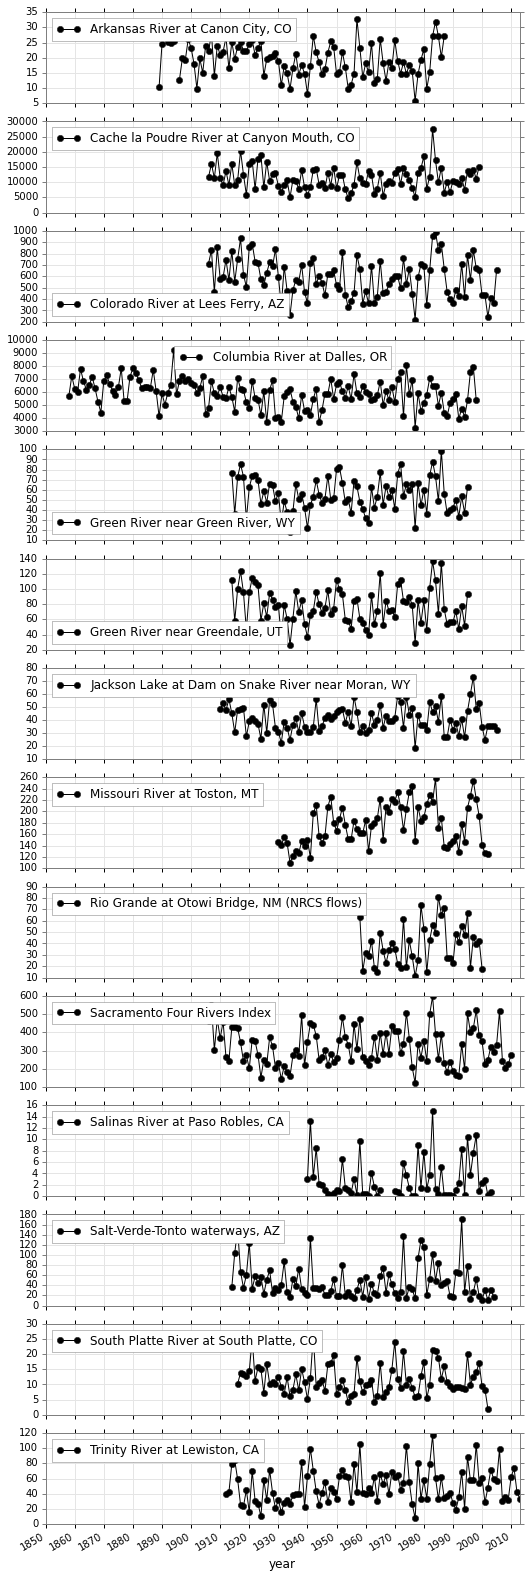

In [7]:
xtickrange = range(rivers.index.get_level_values("year").min() - rivers.index.get_level_values("year").min() % 10, (rivers.index.get_level_values("year").max() - rivers.index.get_level_values("year").max() % 10) + 10, 10)
rivers.unstack()["value"].plot(subplots = True, figsize = (8.5, 30), style = "-o", xticks = xtickrange)

Looks like we're going to need to be careful of missing data in the middle of some series.

Not all of the series are normally distributed. There are a couple ways to handle this. We could do something like below (the Box-Cox). We could also look at a gamma-based SPI.

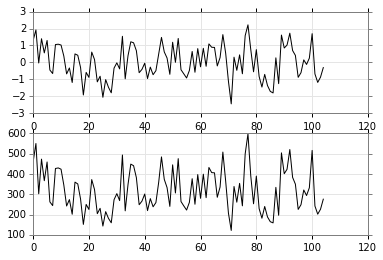

In [6]:
plt.subplot(2, 1, 1)
sac_trans = stats.boxcox(rivers.query("gagename == 'Sacramento Four Rivers Index'")["value"])[0]
plt.plot((sac_trans - sac_trans.mean())/sac_trans.std())
plt.subplot(2, 1, 2)
plt.plot(rivers.query("gagename == 'Sacramento Four Rivers Index'")["value"])

Lets put it into a simple function that we with Pandas' `transform` method. I'm putting this in the `tools.py` file so we can draw on it elsewhere. It is originally based on MATLAB code that computes SPI, written by Taesam Lee.

Now lets play with this SPI-based index.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6f2586bb70>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f6f2555b208>], dtype=object)

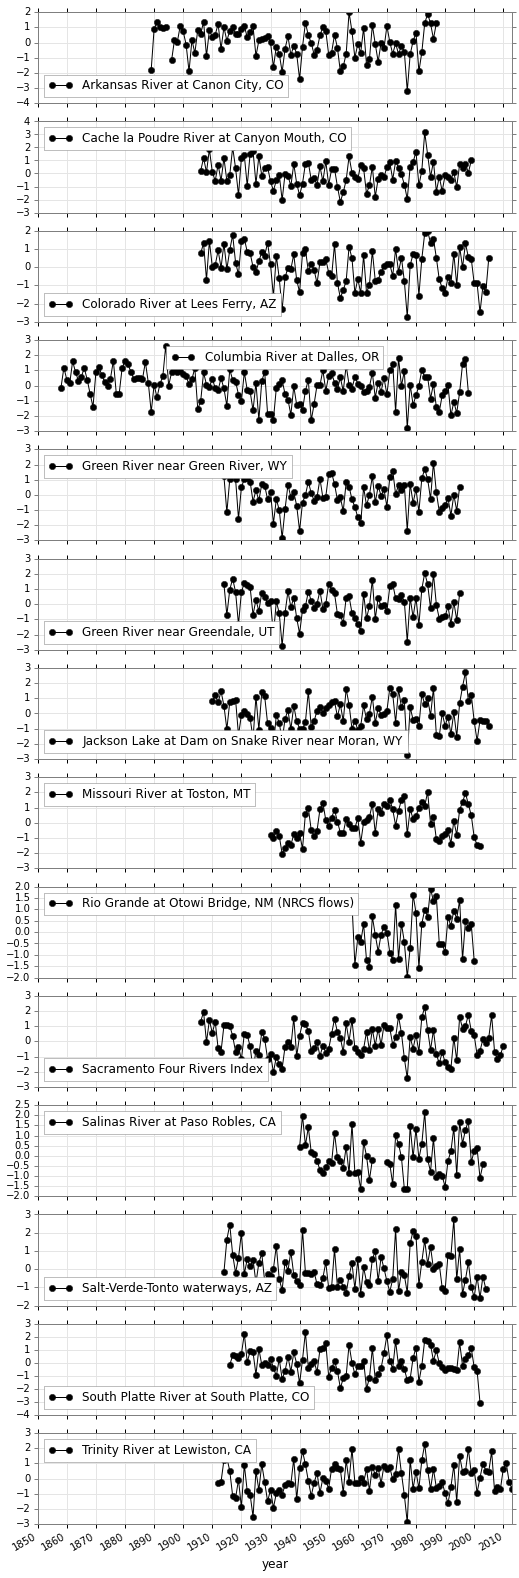

In [8]:
rivers_gamma = rivers.groupby(level = "gagename").transform(tools.spigamma)
rivers_gamma.unstack()["value"].plot(subplots = True, color = "k", figsize = (8.5, 30), style = "-o", xticks = xtickrange)


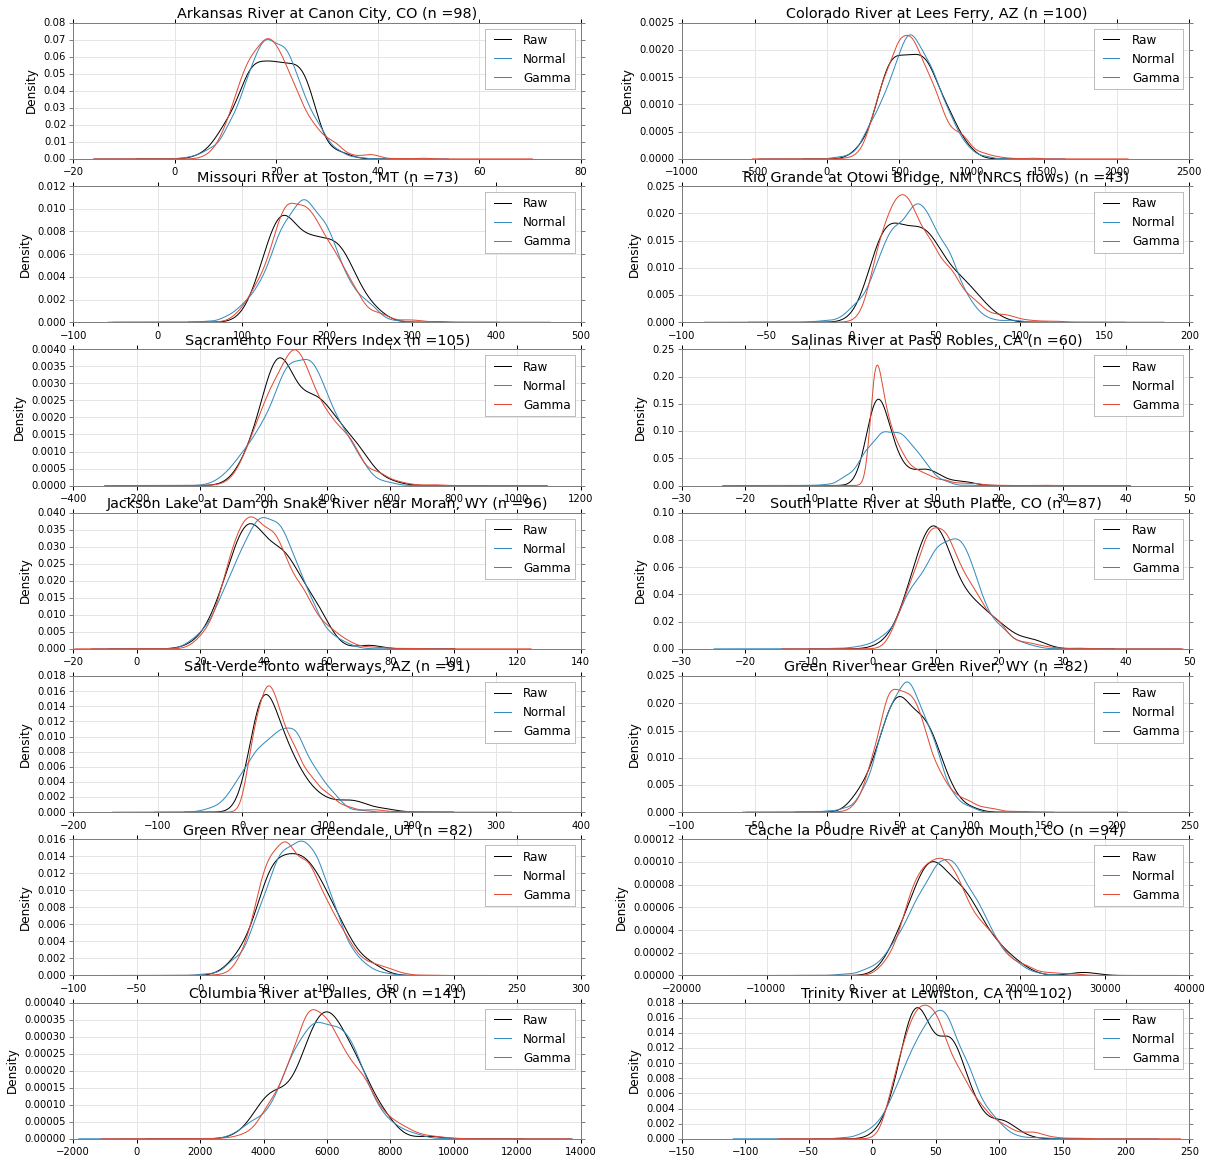

In [11]:
rivernames = rivers.index.get_level_values("gagename").unique()
fig = plt.figure(figsize = (20, 20))
for i in range(len(rivernames)):
    g = rivernames[i]
    plt.subplot(np.ceil(len(rivernames)/2), 2, i + 1)
    q = "gagename == '%s'" % g
    target = rivers.query(q)["value"]
    zero_mask = target == 0
    raw = target.plot(kind = "kde", label = "Raw")
    g_shape, g_loc, g_scale = stats.gamma.fit(target[~zero_mask], floc = 0)
    normal = pd.Series(np.random.normal(target.mean(), target.std(), 1500)).plot(kind = "kde",label = "Normal")
    gamma = pd.Series(np.random.gamma(g_shape, g_scale, 1500)).plot(kind = "kde", label = "Gamma")
    plt.legend()
    plt.title(g + " (n =" + str(len(target)) + ")")
# fig.legend((raw, normal, gamma), ("Raw", "Normal", "Gamma"), "lower left")
plt.show()

Okay, this shows how the gamma-basedSPI method compares with a normal distribution and the raw data. Be sure to compare performance in the tails of the distributions. We might have justification for using this method with a Pearson Type III distribution to get better fits on the lower tails of the distributions.

In [9]:
rivers.xs(("Colorado River at Lees Ferry, AZ", 1954), level = ("gagename", "year"))

,,value
year,gagename,
1954,"Colorado River at Lees Ferry, AZ",327.089842


In [10]:
rivers_gamma.xs(("Colorado River at Lees Ferry, AZ", 1954), level = ("gagename", "year"))

,,value
year,gagename,
1954,"Colorado River at Lees Ferry, AZ",-1.695174
